## Import

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-whitegrid')
plt.rcParams.update({'font.size': 32})
plt.rcParams["figure.figsize"] = (12,8)
import torch
import numpy as np
import scipy.signal
import scipy.io
import pandas as pd
import itertools
from itertools import product

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import random

In [4]:
import h5py

## Data import

In [5]:
fs = 50e3

In [6]:
dataset = h5py.File('dataset_.hdf5', 'r')

In [7]:
class H5Dataset:    
    def __init__(self, h5dataset, segment_size = 1):
        self.dataset  = h5dataset
        self.ds_parts = list(self.dataset.keys())
        self.seg_size = int(segment_size)

    def visit(self):
        self.dataset.visit(lambda name: print(name))
            
    def inspect(self):
        for key in self.ds_parts:
            part = self.dataset[key]
            info = f'Name {key},\tType {type(part)}'
            info +=f' Shape {part.shape}, DType {part.dtype}'
            if isinstance(self.seg_size,int):
                info +=f' N segments {part.shape[1]//self.seg_size}'    
            print(info)
    
    def __len__(self):
        return self.length
    
    def get_source(self, part, source, label = None):
        if self.seg_size is None: raise ValueError
        
        source_data = self.dataset[part][source]
        
        segment = source_data.reshape(-1,self.seg_size)
        
        if label is None:
            label = source
        target  = label * np.ones(segment.shape[0])
        return segment, target

    def part(self, part_name):
        return self.dataset[part_name]
    
    def get_range(self, part, sources = None, segments = None, label = None):
        if self.seg_size is None: raise ValueError
        
        data = self.dataset[part]
        if sources is None:  sources  = (0,data.shape[0])
        if segments is None: segments = (0,data.shape[1]//self.seg_size) 
        sources  = (max(0,int(sources[0])),min(data.shape[0],int(sources[1])))    
        segments = (segments[0]*self.seg_size,segments[1]*self.seg_size)  
        segments = (max(0,int(segments[0])),min(data.shape[1],int(segments[1])))

        return data[sources[0]:sources[1],segments[0]:segments[1] ]
        
    

In [8]:
ds = H5Dataset(dataset, segment_size=int(10e3))
ds.inspect()

Name x_test_1,	Type <class 'h5py._hl.dataset.Dataset'> Shape (20, 12500000), DType float32 N segments 1250
Name x_test_2,	Type <class 'h5py._hl.dataset.Dataset'> Shape (20, 12500000), DType float32 N segments 1250
Name x_train_1,	Type <class 'h5py._hl.dataset.Dataset'> Shape (20, 12500000), DType float32 N segments 1250
Name x_train_2,	Type <class 'h5py._hl.dataset.Dataset'> Shape (20, 12500000), DType float32 N segments 1250


In [9]:
part = ds.part('x_test_1')

In [10]:
range_ = ds.get_range('x_test_1')
print(range_.shape)

(20, 12500000)


In [14]:
range_ = ds.get_range('x_test_1',(0,2))
print(range_.shape)

(2, 12500000)


we have period about 1000 points

(1250, 10000) (1250,)


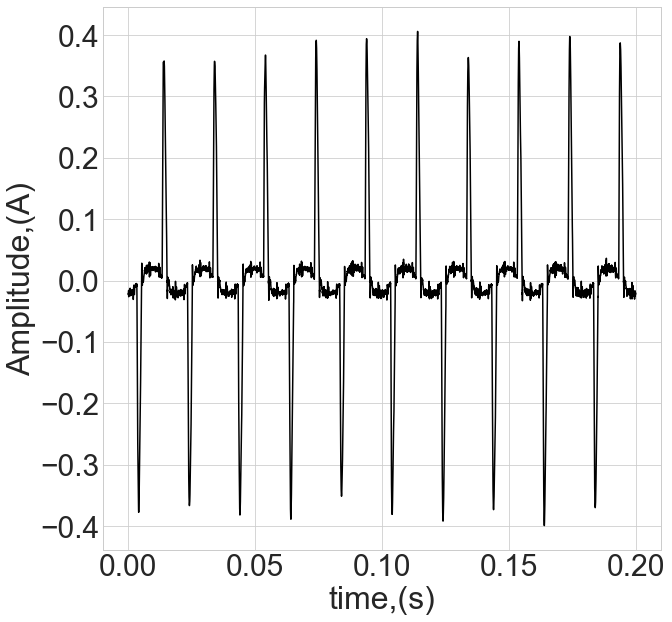

In [33]:
x_,y_ = ds.get_source('x_test_1',0)

id_ = 0

print(x_.shape,y_.shape)
time = np.arange(x_[id_].size)/fs
ff   = np.log10(fs*np.arange(x_[id_].size)/x_[id_].size)

fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.plot(time,x_[id_], c='black'); 
ax.set_xlabel('time,(s)')
ax.set_ylabel('Amplitude,(A)')
ax.tick_params(axis='both', which='major', labelsize=30)

plt.grid(True)
plt.savefig('TypicalSignal_.pdf', dpi=250, format='pdf', bbox_inches='tight' )
plt.show()

(1250, 10000) (1250,)


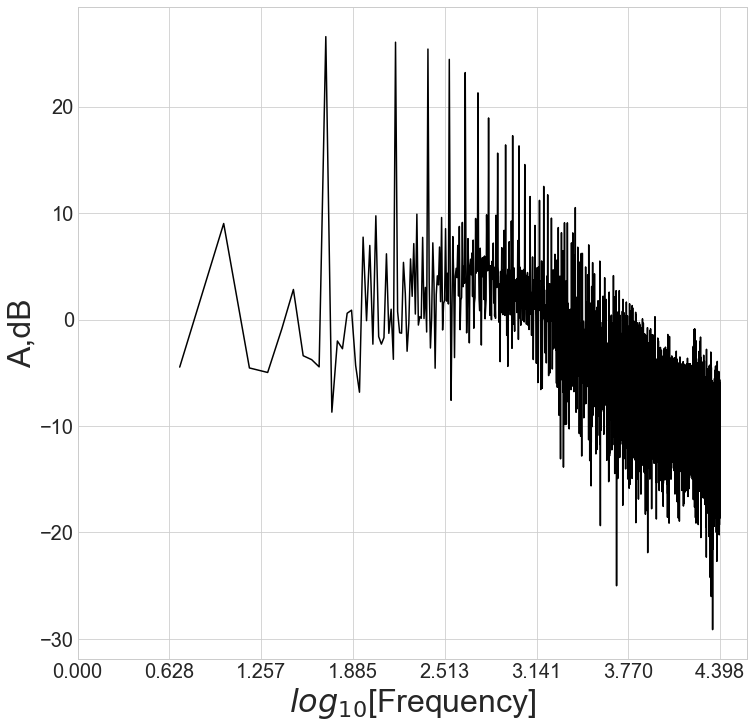

In [18]:
x_,y_ = ds.get_source('x_test_1',0)

id_ = 0

print(x_.shape,y_.shape)
time = np.arange(x_[id_].size)/fs
ff   = np.log10(fs*np.arange(x_[id_].size)/x_[id_].size)

fig, ax = plt.subplots(1,1,figsize=(12,12))
ax.plot(ff[:x_[id_].size//2],
            10*np.log10(ut.afft(x_[id_])[:x_[id_].size//2]), c='black'); 
ax.set_xlabel('$log_{10}$[Frequency]')
ax.set_ylabel('A,dB')
ax.set_xticks(np.linspace(0, ff[x_[id_].size//2], num=8))
ax.tick_params(axis='both', which='major', labelsize=20)

plt.grid(True)
plt.savefig('TypicalSignal_fft-.pdf', dpi=250, format='pdf', bbox_inches='tight' )
plt.show()

(1250, 10000) (1250,)


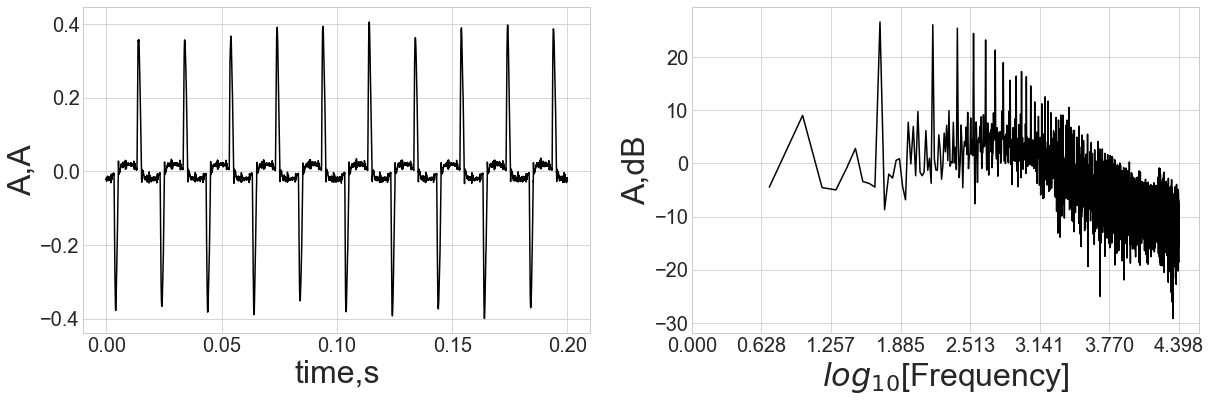

In [19]:
x_,y_ = ds.get_source('x_test_1',0)

id_ = 0

print(x_.shape,y_.shape)
time = np.arange(x_[id_].size)/fs
ff   = np.log10(fs*np.arange(x_[id_].size)/x_[id_].size)

fig, axs = plt.subplots(1,2,figsize=(20,6))
axs[0].plot(time,x_[id_], c='black'); 
axs[0].set_xlabel('time,s')
axs[0].set_ylabel('A,A')
axs[0].tick_params(axis='both', which='major', labelsize=20)

axs[1].plot(ff[:x_[id_].size//2],
            10*np.log10(ut.afft(x_[id_])[:x_[id_].size//2]), c='black'); 
axs[1].set_xlabel('$log_{10}$[Frequency]')
axs[1].set_ylabel('A,dB')
axs[1].set_xticks(np.linspace(0, ff[x_[id_].size//2], num=8))
axs[1].tick_params(axis='both', which='major', labelsize=20)
plt.grid(True)
plt.savefig('TypicalSignal.pdf', dpi=250, format='pdf', bbox_inches='tight' )
plt.show()


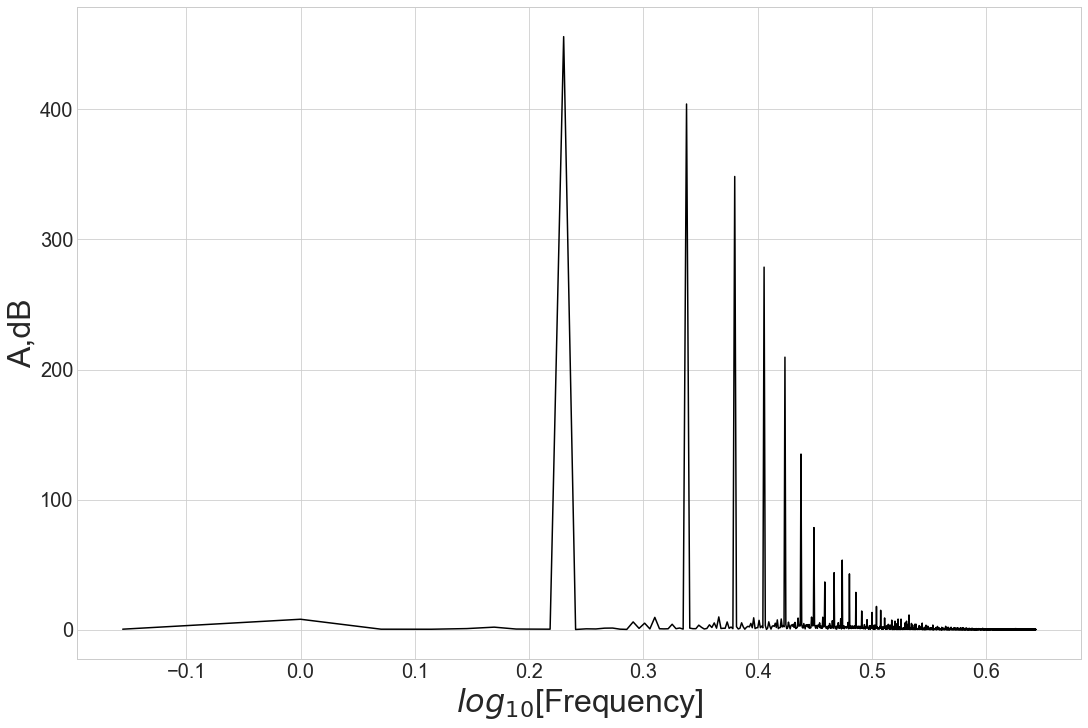

In [20]:
fig, ax = plt.subplots(1,1,figsize=(18,12))

ax.plot(np.log10(ff[:x_[id_].size//2]),
            ut.afft(x_[id_])[:x_[id_].size//2], c='black'); 
ax.set_xlabel('$log_{10}$[Frequency]')
ax.set_ylabel('A,dB')
# ax.set_xticks(np.linspace(0, np.log10(ff[x_[id_].size//2]), num=7))

ax.tick_params(axis='both', which='major', labelsize=20)
plt.grid(True)
plt.savefig('TypicalSignal_Log_fft.pdf', dpi=250, format='pdf', bbox_inches='tight' )
plt.show()

(1250, 10000) (1250,)


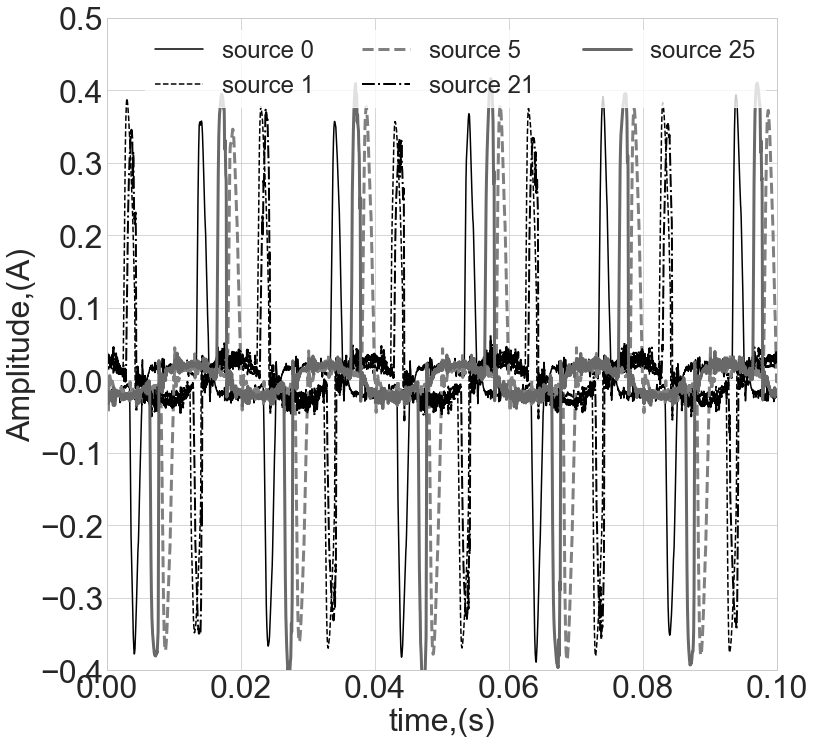

In [36]:
print(x_.shape,y_.shape)
time = np.arange(x_[id_].size)/fs

fig, axs = plt.subplots(1,1,figsize=(12,12))

x_,y_ = ds.get_source('x_test_1',0)
id_ = 0
axs.plot(time,x_[id_], c='black', label = 'source 0'); 

x_,y_ = ds.get_source('x_test_1',1)
id_ = 0
axs.plot(time,x_[id_], linestyle='--', color = 'black', label = 'source 1'); 


x_,y_ = ds.get_source('x_test_1',5)
id_ = 0
axs.plot(time,x_[id_],linestyle='--', linewidth=3, color = 'gray', label = 'source 5'); 

x_,y_ = ds.get_source('x_test_2',1)
id_ = 0
axs.plot(time,x_[id_], linestyle='-.', linewidth=2, color = 'black', label = 'source 21');

x_,y_ = ds.get_source('x_test_2',5)
id_ = 0
axs.plot(time,x_[id_], linestyle='-', linewidth=3, color = 'dimgray', label = 'source 25');

axs.set_xlabel('time,(s)')
axs.set_ylabel('Amplitude,(A)')
axs.tick_params(axis='both', which='major', labelsize=32)
axs.set_xlim([0, 0.1])
axs.set_ylim([-0.4, 0.5])

# axs.set_title('Typical Signals For Several Sources', fontsize = 42)

legend = axs.legend(ncol = 3, fontsize = 24, frameon = 1, loc = 'upper right')
frame = legend.get_frame()
frame.set_color('white')

plt.grid(True)
plt.savefig('TypicalSignals_by_source.pdf', dpi=250, format='pdf', bbox_inches='tight' )
plt.show()


(1250, 10000) (1250,)


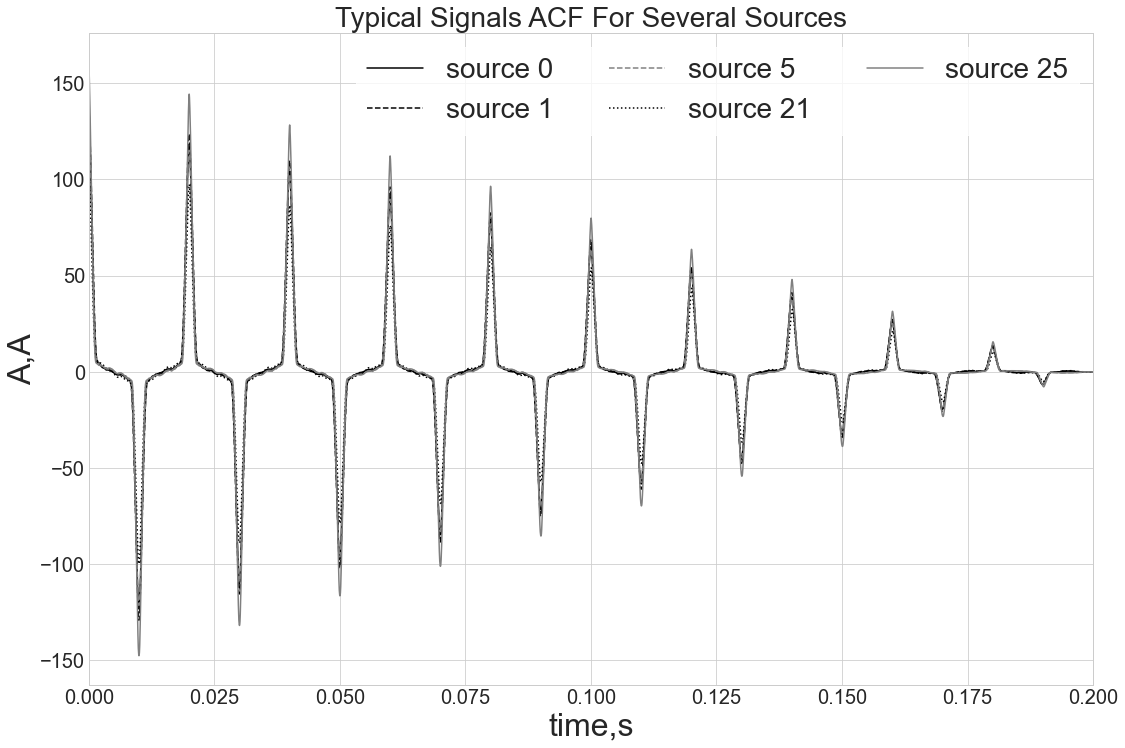

In [18]:
f = lambda x: ut.autocorrelation(x)

print(x_.shape,y_.shape)
time = np.arange(x_[id_].size)/fs

fig, axs = plt.subplots(1,1,figsize=(18,12))

x_,y_ = ds.get_source('x_test_1',0)
id_ = 0
axs.plot(time,f(x_[id_]), c='black', label = 'source 0'); 

x_,y_ = ds.get_source('x_test_1',1)
id_ = 0
axs.plot(time,f(x_[id_]), linestyle='--', color = 'black', label = 'source 1'); 


x_,y_ = ds.get_source('x_test_1',5)
id_ = 0
axs.plot(time,f(x_[id_]),linestyle='--', color = 'gray', label = 'source 5'); 

x_,y_ = ds.get_source('x_test_2',1)
id_ = 0
axs.plot(time,f(x_[id_]), linestyle=':', color = 'black', label = 'source 21');

x_,y_ = ds.get_source('x_test_2',5)
id_ = 0
axs.plot(time,f(x_[id_]), linestyle='-', color = 'gray', label = 'source 25');

axs.set_xlabel('time,s')
axs.set_ylabel('A,A')
axs.tick_params(axis='both', which='major', labelsize=20)
axs.set_xlim([0, 0.2])
# axs.set_ylim([-0.5, 0.5])

axs.set_title('Typical Signals ACF For Several Sources', fontsize = 28)

legend = axs.legend(ncol = 3, fontsize = 28, frameon = 1, loc = 'upper right')
frame = legend.get_frame()
frame.set_color('white')

plt.grid(True)
plt.savefig('TypicalSignals_ACF_by_source.pdf', dpi=250, format='pdf', bbox_inches='tight' )
plt.show()


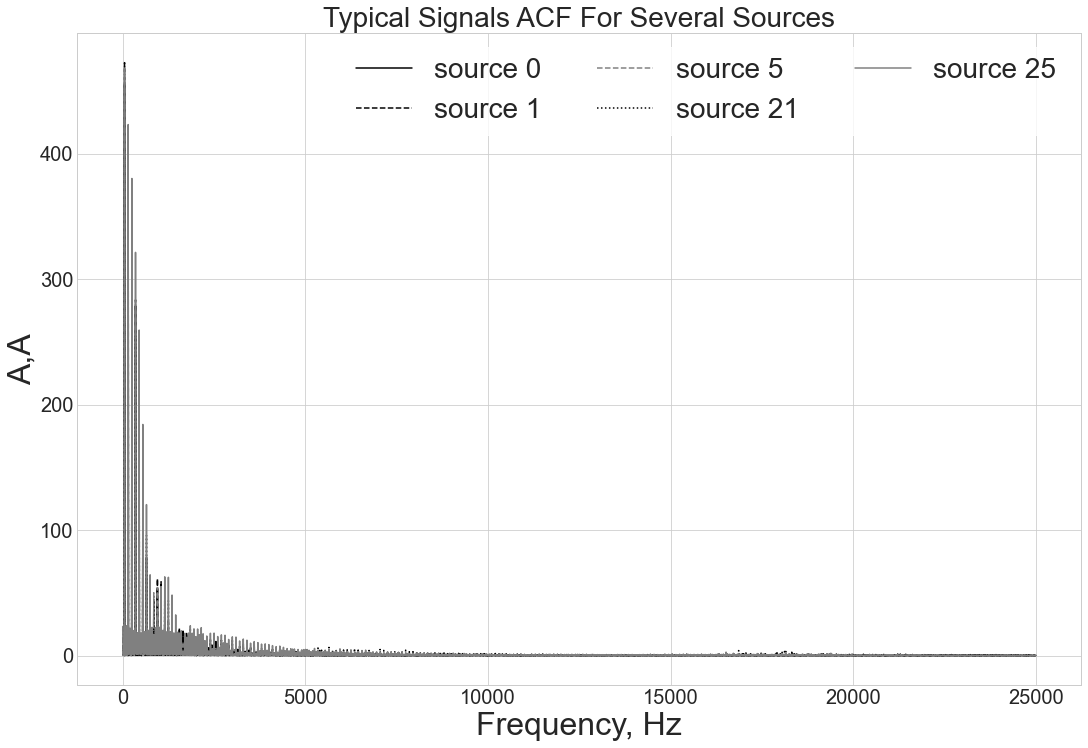

In [19]:

x_,y_ = ds.get_source('x_test_1',0)
id_ = 0

f = lambda x: ut.afft(x)[:x.size//2]

time = np.arange(x_[id_].size)*fs/x_[id_].size
time = time[:x_[id_].size//2]

fig, axs = plt.subplots(1,1,figsize=(18,12))

x_,y_ = ds.get_source('x_test_1',0)
id_ = 0
axs.plot(time,f(x_[id_]), c='black', label = 'source 0'); 

x_,y_ = ds.get_source('x_test_1',1)
id_ = 0
axs.plot(time,f(x_[id_]), linestyle='--', color = 'black', label = 'source 1'); 


x_,y_ = ds.get_source('x_test_1',5)
id_ = 0
axs.plot(time,f(x_[id_]),linestyle='--', color = 'gray', label = 'source 5'); 

x_,y_ = ds.get_source('x_test_2',1)
id_ = 0
axs.plot(time,f(x_[id_]), linestyle=':', color = 'black', label = 'source 21');

x_,y_ = ds.get_source('x_test_2',5)
id_ = 0
axs.plot(time,f(x_[id_]), linestyle='-', color = 'gray', label = 'source 25');

axs.set_xlabel('Frequency, Hz')
axs.set_ylabel('A,A')
axs.tick_params(axis='both', which='major', labelsize=20)
# axs.set_xlim([0, 0.2])
# axs.set_ylim([-0.5, 0.5])

axs.set_title('Typical Signals ACF For Several Sources', fontsize = 28)

legend = axs.legend(ncol = 3, fontsize = 28, frameon = 1, loc = 'upper right')
frame = legend.get_frame()
frame.set_color('white')

plt.grid(True)
plt.savefig('TypicalSignals_AFFT_by_source.pdf', dpi=250, format='pdf', bbox_inches='tight' )
plt.show()


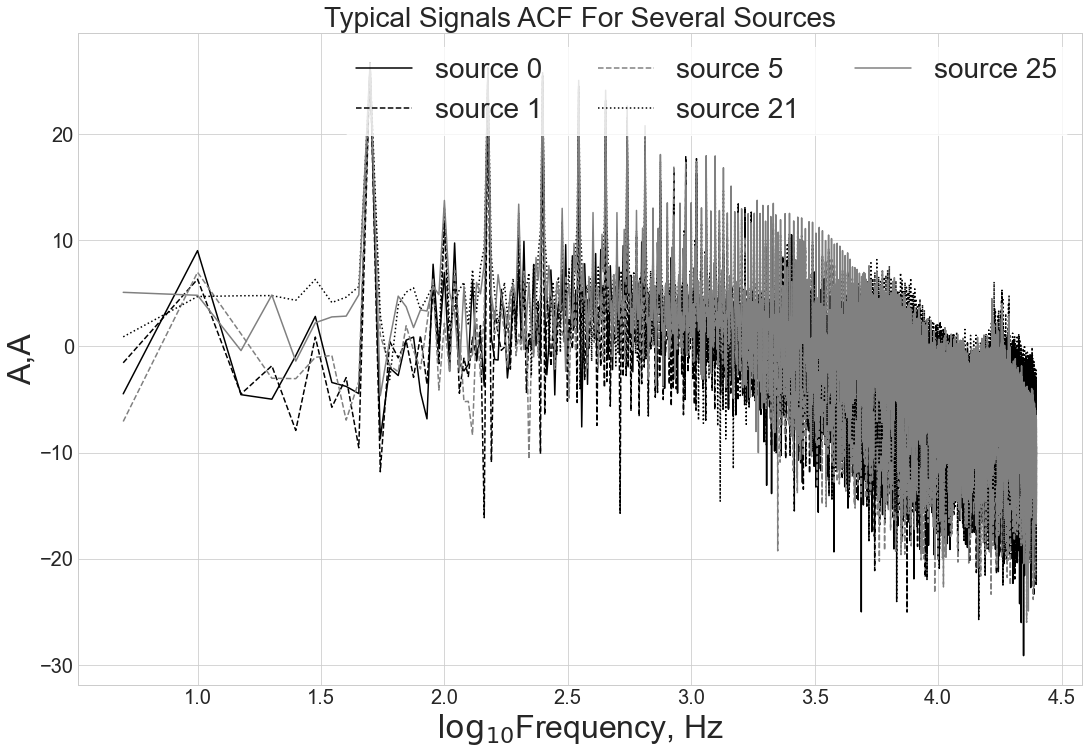

In [20]:

x_,y_ = ds.get_source('x_test_1',0)
id_ = 0

f = lambda x: 10*np.log10(ut.afft(x)[:x.size//2])

time = np.arange(x_[id_].size)*fs/x_[id_].size
time = np.log10(time[:x_[id_].size//2])

fig, axs = plt.subplots(1,1,figsize=(18,12))

x_,y_ = ds.get_source('x_test_1',0)
id_ = 0
axs.plot(time,f(x_[id_]), c='black', label = 'source 0'); 

x_,y_ = ds.get_source('x_test_1',1)
id_ = 0
axs.plot(time,f(x_[id_]), linestyle='--', color = 'black', label = 'source 1'); 


x_,y_ = ds.get_source('x_test_1',5)
id_ = 0
axs.plot(time,f(x_[id_]),linestyle='--', color = 'gray', label = 'source 5'); 

x_,y_ = ds.get_source('x_test_2',1)
id_ = 0
axs.plot(time,f(x_[id_]), linestyle=':', color = 'black', label = 'source 21');

x_,y_ = ds.get_source('x_test_2',5)
id_ = 0
axs.plot(time,f(x_[id_]), linestyle='-', color = 'gray', label = 'source 25');

axs.set_xlabel('$\log_{10}$Frequency, Hz')
axs.set_ylabel('A,A')
axs.tick_params(axis='both', which='major', labelsize=20)
# axs.set_xlim([0, 0.2])
# axs.set_ylim([-0.5, 0.5])

axs.set_title('Typical Signals ACF For Several Sources', fontsize = 28)

legend = axs.legend(ncol = 3, fontsize = 28, frameon = 1, loc = 'upper right')
frame = legend.get_frame()
frame.set_color('white')

plt.grid(True)
plt.savefig('TypicalSignals_AFFT_by_source.pdf', dpi=250, format='pdf', bbox_inches='tight' )
plt.show()


###### 